### Table of Contents

- [Load And Split Data](#Load-And-Split-Data)
- [Train Predictive Modes](#Train-Predictive-Modes)
    - [Logistic Regression](#Logistic-Regression)
    - [Decision Tree Classifier](#Decision-Tree-Classifier)
    - [Random Forest](#Random-Forest)
    - [Extra Trees](#Extra-Trees)
    - [Gradient Boosting Machine](#Gradient-Boosting-Machine)
    - [Multi-Layer Perceptron](#Multi-Layer-Perceptron)
- [Plot ROC And PRC Curves](#Plot-ROC-And-PRC-Curves)
- [Build MMS - Model Scoring Service](#Build-MMS---Model-Scoring-Service)
- [Tune Hyperparameters](#Tune-Hyperparameters)
    - [Semi-Automatic Search Through Hyperspaces](#Semi-Automatic-Search-Through-Hyperspaces)
    - [Validation Curves](#Validation-Curves)

In [2]:
# sometimes during execution (especially when searching thru hyperspace) a slew of Warnings erupts
# to supress them (if you've gotten tired of them) run this cell

import warnings
warnings.filterwarnings("ignore")


In [ ]:
# common settings

# adjust settings to show all cols and rows
pd.options.display.max_columns = 80
pd.options.display.max_rows = 20


In [1]:
# common imports

import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.model_selection import (KFold, StratifiedKFold,
                                     train_test_split, 
                                     GridSearchCV,
                                     RandomizedSearchCV,
                                     cross_val_score, 
                                     validation_curve)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import (accuracy_score,
                             precision_score, 
                             recall_score, 
                             f1_score,
                             average_precision_score,
                             roc_curve, 
                             auc, 
                             roc_auc_score,
                             precision_recall_curve,
                             jaccard_similarity_score,
                             hamming_loss,
                             confusion_matrix, 
                             classification_report)


### Load And Split Data

In [3]:
from LC_data_prep import load_and_prep_data

In [4]:
# load the training data set
df = load_and_prep_data()
df.shape

(621167, 37)

In [5]:
# set X and y
X = df.iloc[:,1:] # predictor variables
y = df["DEFAULT"] # response/target variable 

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
[_.shape for _ in (X_train, X_test, y_train, y_test)]

[(465875, 36), (155292, 36), (465875,), (155292,)]

### Train Predictive Modes

#### Logistic Regression

In [7]:
# instantiate model
lrc = LogisticRegression(class_weight='balanced', # since the data is biased use class_weight='balanced'!
                        C=0.1, 
                        fit_intercept=True, 
                        intercept_scaling=1, 
                        max_iter=100,
                        penalty='l2',
                        solver='liblinear', 
                        tol=0.0001,
                        n_jobs=-1)

# fit it to the data
lrc.fit(X_train, y_train)

# show the classification report
predicted = lrc.predict(X_test)
expected = y_test
print(classification_report(expected, predicted))

             precision    recall  f1-score   support

          0       0.99      0.95      0.97    145098
          1       0.56      0.83      0.67     10194

avg / total       0.96      0.95      0.95    155292



#### Decision Tree Classifier

In [8]:
# repeat for Decision Tree Classifier
dtc = DecisionTreeClassifier(criterion="entropy", 
                             max_depth=10, 
                             min_samples_leaf=14, 
                             min_samples_split=15)

dtc.fit(X_train, y_train)

predicted = dtc.predict(X_test)
expected = y_test
print(classification_report(expected, predicted))

             precision    recall  f1-score   support

          0       0.98      1.00      0.99    145098
          1       0.99      0.78      0.87     10194

avg / total       0.99      0.99      0.98    155292



#### Random Forest

In [9]:
# ditto
rfc = RandomForestClassifier(class_weight='balanced', 
                             bootstrap=True,
                             criterion='gini', 
                             max_depth=None, 
                             max_features='auto',
                             min_samples_split=2,
                             n_estimators=100,
                             n_jobs=-1)

rfc.fit(X_train, y_train)

predicted = rfc.predict(X_test)
expected = y_test
print(classification_report(expected, predicted))

             precision    recall  f1-score   support

          0       0.98      1.00      0.99    145098
          1       1.00      0.78      0.87     10194

avg / total       0.99      0.99      0.98    155292



#### Extra Trees

In [10]:
etc = ExtraTreesClassifier(class_weight='balanced', 
                           bootstrap=False, 
                           criterion='gini', 
                           max_depth=None, 
                           max_features='auto',
                           max_leaf_nodes=None, 
                           min_impurity_decrease=0.0,
                           min_impurity_split=None, 
                           min_samples_leaf=1,
                           min_samples_split=2, 
                           min_weight_fraction_leaf=0.0,
                           n_estimators=100, 
                           n_jobs=-1)

etc.fit(X_train, y_train)

predicted = etc.predict(X_test)
expected = y_test
print(classification_report(expected, predicted))

             precision    recall  f1-score   support

          0       0.98      1.00      0.99    145098
          1       1.00      0.77      0.87     10194

avg / total       0.98      0.98      0.98    155292



#### Gradient Boosting Machine

In [11]:
gbc = GradientBoostingClassifier( # This GBM does not have class_weight='balanced' to balance biased class count
                                  criterion='friedman_mse',
                                  learning_rate=0.1, 
                                  loss='exponential', 
                                  max_depth=5, 
                                  min_samples_leaf=1, 
                                  min_samples_split=2,
                                  min_weight_fraction_leaf=0.0, 
                                  n_estimators=200,
                                  presort='auto', 
                                  subsample=1 )

gbc.fit(X_train, y_train)

predicted = gbc.predict(X_test)
expected = y_test
print(classification_report(expected, predicted))

             precision    recall  f1-score   support

          0       0.98      1.00      0.99    145098
          1       1.00      0.78      0.88     10194

avg / total       0.99      0.99      0.98    155292



#### Multi-Layer Perceptron

In [12]:
N = df.shape[1]

mlp = MLPClassifier( hidden_layer_sizes=(N, N, 1),  # ditto, no class_weight='balanced'
                     solver='adam', 
                     activation='tanh', # activation='relu',
                     alpha=1e-05,
                     batch_size='auto', 
                     beta_1=0.9, 
                     beta_2=0.999, 
                     learning_rate='adaptive', 
                     validation_fraction=0.1,
                     tol=0.0001,
                     early_stopping=True,
                     epsilon=1e-08,
                     learning_rate_init=0.001, 
                     max_iter=300, 
                     momentum=0.9,
                     nesterovs_momentum=True, 
                     power_t=0.5, 
                     shuffle=True, 
                    )
# MLP is sensitive to feature scaling, so you'd better scale the data
ss_mlp = make_pipeline(StandardScaler(), mlp)
ss_mlp.fit(X_train, y_train)

predicted = ss_mlp.predict(X_test)
expected = y_test
print(classification_report(expected, predicted))

             precision    recall  f1-score   support

          0       0.99      1.00      0.99    145098
          1       0.98      0.82      0.90     10194

avg / total       0.99      0.99      0.99    155292



In [22]:
# keep track of the models
models_list = [lrc, dtc, rfc, etc, gbc, ss_mlp]

### Plot ROC And PRC Curves

In [1]:
# let's define some funcs for reuse from other notebooks

In [2]:
%%writefile LC_MMS.py
    
#
# LC_MMS module defines the MMS service 
# as well as some other functions useful for model tuning and selection
#
     
import os
from operator import itemgetter

# cloudpickle supports pickling for lambda expressions, functions and classes 
# defined interactively in the __main__ module
try:
    import cloudpickle as pickle
except ImportError:
    import pickle

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.model_selection import (KFold, StratifiedKFold,
                                     train_test_split, 
                                     GridSearchCV,
                                     RandomizedSearchCV,
                                     cross_val_score, 
                                     validation_curve)

from sklearn.metrics import (accuracy_score,
                             precision_score, 
                             recall_score, 
                             f1_score,
                             average_precision_score,
                             roc_curve, 
                             auc, 
                             roc_auc_score,
                             precision_recall_curve,
                             jaccard_similarity_score,
                             hamming_loss,
                             confusion_matrix, 
                             classification_report)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
    

Overwriting LC_MMS.py


In [3]:
%%writefile -a LC_MMS.py
    
#
# define the func to plot ROC curves
#
def plot_ROCs(clfs, X, y, use_predict_proba=True, ax=None):
    """
    Plot ROC Curves for the passed classifiers.
    
    Parameters
    -----------
    clfs : iterator of classifiers
    X    : predictor variables
    y    : response variable
    use_decision_function : either decision_function() or predict_proba()
    
    Returns
    --------
    pyplot axes
    """
    
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        
    ax.set_xlim([-.02, 1.02])
    ax.set_ylim([-.02, 1.02])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.plot([0, 1], [0, 1], 'k--', alpha=.5, lw=2, label="Random Chance")
    
    # shuffle and split training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    
    for clf in clfs:   
        
        # compute scores
        clf.fit(X_train, y_train)
        
        if use_predict_proba:
            y_score = clf.predict_proba(X_test)[:,1]
        else:
            y_score = clf.decision_function(X_test)
            
        # compute ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        
        # extract the clf's name
        clf_name = clf.__class__.__name__
        if isinstance( clf, Pipeline):
            clf_name = clf.steps[-1][1].__class__.__name__
            
        # plot ROC curves
        ax.plot(fpr, tpr, ls=':', lw=3, label= '{clf} (AUC = {roc_auc:0.2f})'.format(clf=clf_name, roc_auc=roc_auc),)

        
    ax.legend(loc="lower right", framealpha=.5)
    ax.set_title('ROC Curves')
    
    return ax
    

Appending to LC_MMS.py


In [4]:
%%writefile -a LC_MMS.py
    
#
# define func to plot PRC 
#
def plot_PRCs(clfs, X, y, use_predict_proba=True, ax=None):
    """
    Plot PR Curves for the passed classifiers.
    
    Parameters
    -----------
    clfs : iterator of classifiers
    X    : predictor variables
    y    : response variable
    predict_proba : whether to use predict_proba or decision_function
    
    Returns
    --------
    pyplot axes
    """
    
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)    

    ax.set_xlim([-.02, 1.02])
    ax.set_ylim([-.02, 1.02])
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    
    # shuffle and split training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    
    p, n = y_test.value_counts().sort_index(ascending=False)
    baseline = p/(p+n)
    ax.plot([0, 1], [baseline, baseline], 'k--', alpha=.5, lw=2, label="Random Chance")

    
    for clf in clfs:
        
        # compute scores
        clf.fit(X_train, y_train)
        
        if use_predict_proba:
            y_score = clf.predict_proba(X_test)[:,1]
        else:
            y_score = clf.decision_function(X_test)
            
        # compute P, R and precision
        precision, recall, thresholds = precision_recall_curve(y_test, y_score)
        average_precision = average_precision_score(y_test, y_score)
        
        # extract the clf's name
        clf_name = clf.__class__.__name__
        if isinstance( clf, Pipeline):
            clf_name = clf.steps[-1][1].__class__.__name__
            
        # plot PRC
        ax.plot(recall, precision, ls=':', lw=3, label='{clf} (AP = {ap:0.2f})'.format(clf=clf_name, ap=average_precision))

    ax.legend(loc='center left', framealpha=.5)
    ax.set_title('PR Curves')
    
    return ax


Appending to LC_MMS.py


In [27]:
from LC_MMS import plot_ROCs, plot_PRCs

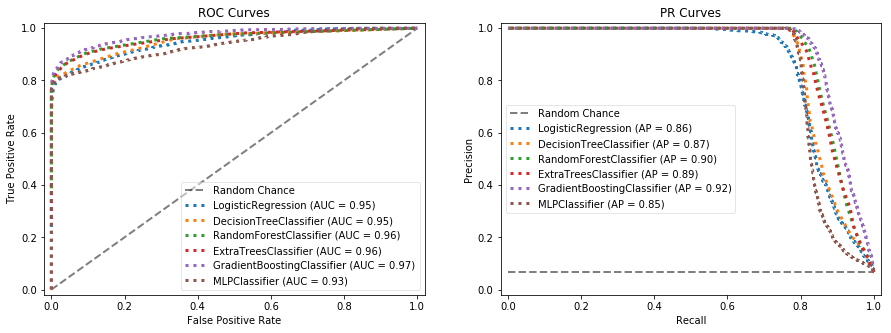

In [28]:
# since MLPClassifier does not have decision_function() implemented, then 
# let's use predict_probas() instead, when plotting ROC and PRC

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))

plot_ROCs(models_list, X_test, y_test, use_predict_proba=True, ax=ax1)
plot_PRCs(models_list, X_test, y_test, use_predict_proba=True, ax=ax2);

### Build MMS - Model Scoring Service

In [5]:
# we can tune the models' hyperparameters, but before that ...

# let's create MMS (Model Management Service) 
# the service will manage the trained and ready to use predictive models

# Ideas for the MMS's interface are:
#  - score_model('model_name', est, X, y)
#  - list_models()
#  - save_models()
#  - load_models()
#  - get_model('model_name')


In [6]:
%%writefile -a LC_MMS.py
    
    
#
# define MMS Model Management Service
#
class MMS:
    """
    Model Management Service
    - scores the model classifiers
    - keeps track of the scored and ready-to-use models
    - pickles and unpickles them
    - loads models based on a best score
    """
    
    # available scoring criteria
    scoring_criteria_list = ['accuracy', 'precision', 'recall', 'f1', 'neg_log_loss', 'roc_auc']

    
    def __init__(self,file_name="LC_MMS_predictive_models.pkl"):
        
        self.LC_predictive_models_file_name = file_name
        
        self._model_list = [] # this keeps all the predictive models
        
        if os.path.isfile(self.LC_predictive_models_file_name):
            self.load_models()
        
        return
    
    
    def score_model(self, model, X, y, fit_and_add=True): 
        """
        Score the estimator on a number of scoring criteria, 
        then fit the best one and hold onto it in the intenal _model_list.
        
        Parameters
        -----------
        model : the classifier to be scored (can be a pipeline)
        X : the predictive variables
        y : the response variable
        """
        
        model_name = ""
        if isinstance(model, Pipeline):
            
            # !! these imports are only needed here; so remove them when keras.save_model() is implemented
            # KerasClassifier run in a pipeline (with scaler)
            import keras
            from keras.wrappers.scikit_learn import KerasClassifier
            if isinstance(model.steps[-1][1].__class__, KerasClassifier):                
                    raise  NotImplementedError("score_model()/save() not implemented for Keras/Tensorflow")
            
            
            for step in model.steps:
                model_name += "-" + step[1].__class__.__name__
                model 
            model_name = model_name.lstrip('-')    

        else:
            model_name = model.__class__.__name__
            

        print('Scoring model', model_name,'by %s' % (self.scoring_criteria_list))
        scores = []
        
        for score_name in self.scoring_criteria_list:
            
            results = cross_val_score(model, X, y, cv=StratifiedKFold(n_splits=3, shuffle=True), scoring=score_name)
            score_mean, score_std = results.mean(), results.std()
            
            print( ("{score_name}: {score_mean:.3f} (std: {score_std:.3f})"
                    .format(score_name=score_name,score_mean=score_mean, score_std=score_std) ) )
            scores.append(score_mean)
            
        if fit_and_add:
            print("Fitting the model")
            # this is necessary as cross_val_score does not leave the model pretrained
            model.fit(X,y) 
            # _model_list keeps the list of model-binaries, model-name, and scores
            self._model_list.append( [model, model_name] + scores )
            
        
        return scores
        
        
    def save_models(self):
        """
        Save all the models kept in memory
        """
        
        # if the file already exists back it up
        if os.path.isfile(self.LC_predictive_models_file_name):
            os.rename(self.LC_predictive_models_file_name, self.LC_predictive_models_file_name+'-bkp')

        with open(self.LC_predictive_models_file_name , "wb" ) as fh:
            pickle.dump(self._model_list, fh )   
            
        print('"%s" dumped.' % (self.LC_predictive_models_file_name))
            
        return
    
    
    def load_models(self):
        """
        Loads all the models kept on disk
        """

        with open(self.LC_predictive_models_file_name, "rb" ) as fh:
            self._model_list = pickle.load(fh)
            
        # print('"%s" loaded.' % (self.LC_predictive_models_file_name))
        
        return
    
    
    def list_models(self, by_best_score='roc_auc', model_bins_too=False):
        """
        Lists all the models kept in memory
        
        Parameters
        ----------
        by_best_score : one of ...
        
        Returns
        -------
        [list] : list of sorted models
        """
    
        if self._model_list is None:
            self.load_models()
        
        if by_best_score:
            assert by_best_score in self.scoring_criteria_list, "by_best_score='%s' not one of %s" % (by_best_score, self.scoring_criteria_list)
            idx = 2 + self.scoring_criteria_list.index(by_best_score) # skip  1st model binary and 2nd model name
            sorted_model_list = sorted(self._model_list, key=itemgetter(idx), reverse=True)
        else:
            sorted_model_list = sorted(self._model_list, key=itemgetter(1)) # sort by name
            
        if not model_bins_too:
            # discard the model binary from the list
            sorted_model_list = [ rest for bin, *rest in sorted_model_list]
            
        return sorted_model_list

    
    
    def get_model(self, model_name=None, by_best_score='roc_auc'):
        """
        Loads the best model based on the name or a best score
        
        Parameters
        ----------
        model_name :
        by_best_score : 
        
        Returns
        -------
        model : the model
        """        
        
        if model_name:
            model_bin = [model_bin for model_bin, name, *rest in self._model_list if name == model_name][0]
            return model_bin
        
        # else return the best model based on by_best_score criterium
        assert by_best_score in self.scoring_criteria_list, "by_best_score='%s' not one of %s" % (by_best_score, self.scoring_criteria_list)
        model_row = self.list_models(by_best_score=by_best_score, model_bins_too=True)[0] # get the top one from the list
        model_bin = model_row[0] # model binary is the first
        
        return model_bin
    
    
    def del_model(self, model_name):
        """
        Delets a model from the internal _model_list
        
        Parameters
        ----------
        model_name : the model to delete
        
        Returns
        -------
        the popped model
        """
        idx = [i for i, row in enumerate(self._model_list) if row[1] == model_name][0]
        model = self._model_list.pop(idx)
        
        return model
    

    
### THE END of LC_MMS ###

Appending to LC_MMS.py


In [13]:
# reload needed as LC_MMS was imported earlier

from importlib import reload

import LC_MMS
reload(LC_MMS)
from LC_MMS import MMS

mms = MMS()

"LC_MMS_predictive_models.pkl" loaded.


In [32]:
# evaluate these models with optimized hyperparameters and add them to the MMS service
for model in models_list:
    print('Updating MMS with', model)
    print()
    mms.score_model(model,X,y)
    print()
    
mms.save_models()

Updating MMS with LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

Scoring model LogisticRegression by ['accuracy', 'precision', 'recall', 'f1', 'neg_log_loss', 'roc_auc']
accuracy: 0.954 (std: 0.003)
precision: 0.592 (std: 0.036)
recall: 0.830 (std: 0.002)
f1: 0.675 (std: 0.005)
neg_log_loss: -0.209 (std: 0.000)
roc_auc: 0.954 (std: 0.001)
Fitting the model

Updating MMS with DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=14, min_samples_split=15,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Scoring model DecisionTreeClassifier by ['

AttributeError: 'MLPClassifier' object has no attribute 'model'

In [88]:
mms.score_model(ss_mlp,X,y)

Using TensorFlow backend.


Scoring model StandardScaler-MLPClassifier by ['accuracy', 'precision', 'recall', 'f1', 'neg_log_loss', 'roc_auc']
accuracy: 0.987 (std: 0.000)
precision: 0.987 (std: 0.006)
recall: 0.818 (std: 0.010)
f1: 0.892 (std: 0.002)
neg_log_loss: -0.052 (std: 0.002)
roc_auc: 0.979 (std: 0.001)
Fitting the model


In [90]:
mms.save_models()

"LC_MMS_predictive_models.pkl" dumped.


### Tune Hyperparameters

#### Semi-Automatic Search Through Hyperspaces

In [14]:
# let's automate the search for the best hyperparams so that we can do it for multiple algos at one fell swoop

In [15]:
# define helper func to run either GridSearchCV or RandomizedSearchCV depending on
# the number of hyper-parameters passed

def search_best_hyperparams (est, hyper_params, X, y, scoring='neg_log_loss', n_iter=10):
    """
    Searche the hyperparam space for the best params using either GridSearchCV or RandomizedSearchCV.
    
    Parameters
    ----------
    est : estimator
    hyper_params : dict of hyper-params for the estimator
    X   : predictor variables
    y   : response variable
    n_iter : number of iterations
    scoring : loss or gain func used for scoring
    
    Returns
    -------
    est : the estimator with best hyperparams
    """
    
    from operator import mul
    from functools import reduce
    num_params2check = reduce(mul, [len(hyper_params[_]) for _ in hyper_params.keys()], 1)

    if num_params2check < n_iter: # depending on the number of hyperparams to check
        # run Hyperparameter Grid Search
        est_hp = GridSearchCV(est, hyper_params, scoring=scoring, n_jobs=-1)
    else:
        # run Random Hyperparameter Grid Search
        est_hp = RandomizedSearchCV(est, hyper_params, n_iter=n_iter, scoring=scoring, n_jobs=-1)

    est_hp.fit(X, y)
    
    # print out the info for the best est
    print("\nBest Score: %.3f" % est_hp.best_score_ )
    print("\nBest Hyper-Params: %s" % est_hp.best_params_ )   
    print("\nBest Estimator: %s" % est_hp.best_estimator_ ) 

    est = est_hp.best_estimator_
    
    return est


In [19]:
# hyperspaces_to_search holds the estimators, together with their hyperparam spaces
# the hyperspaces should be more extensive, which would require more processing time though.

N = df.shape[1] # this is num of features from df passed as parameter to build a neural net 


hyperspaces_to_search = {
    
    'LogisticRegression': {
        'class_weight':['balanced'],
        'solver':['sag','saga'], # 'sag' can do only 'l2'
        'penalty':['l2'], # 'l1'
        'tol': np.logspace(-4,-3,2),
        'C': np.logspace(-1,1,3),
        'max_iter': [100,200,300],  
        'n_jobs':[-1],
    },
    
    'GradientBoostingClassifier': {
        'loss': ['deviance','exponential'],
        'learning_rate': [0.05,0.1],
        'n_estimators': [100,200,300],
        'max_depth': [3,5],
        'max_features': [None,'sqrt'],            
        'subsample': [1,.8,.5],
    },
    
    'MLPClassifier': {
        'hidden_layer_sizes': [(N,N,1),(N,N,int(N/2),1)],
        'activation': ['tanh','relu'], 
        'solver': ['adam','sgd'], 
        'alpha': np.logspace(-5,-3,3), 
        'learning_rate': ['invscaling','adaptive'], 
        'max_iter': [100,300,500],
        'tol': [0.0001,0.001], 
        'early_stopping': [True], 
    },
    
}

In [20]:
# WARNING!
# this stuff takes a long time to run!

# to hold onto the best models
hyperoptimized_models = []

# search for the best hyperparameters
for est_str in hyperspaces_to_search:
    
    print('Searching hyperspace for:', est_str)
    
    best_est = search_best_hyperparams( eval(est_str+'()' ), 
                                        hyperspaces_to_search[est_str], X, y, 
                                        scoring='roc_auc',
                                        n_iter = 1,  # 1 is just for testing, increase this for serious work
                                      )
    
    hyperoptimized_models.append(best_est)
    
    print()


Searching hyperspace for: LogisticRegression

Best Score: 0.900

Best Hyper-Params: {'tol': 0.001, 'solver': 'sag', 'penalty': 'l2', 'n_jobs': -1, 'max_iter': 100, 'class_weight': 'balanced', 'C': 10.0}

Best Estimator: LogisticRegression(C=10.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='sag', tol=0.001, verbose=0, warm_start=False)

Searching hyperspace for: GradientBoostingClassifier

Best Score: 0.976

Best Hyper-Params: {'subsample': 0.8, 'n_estimators': 200, 'max_features': None, 'max_depth': 5, 'loss': 'deviance', 'learning_rate': 0.05}

Best Estimator: GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, m

In [ ]:
# evaluate these models with optimized hyperparameters and add them to the MMS service
for model in hyperoptimized_models:
    print('Updating MMS with', model)
    print()
    mms.score_model(model,X,y)
    print()

mms.list_models()

In [ ]:
mms.save_models()

#### Validation Curves

In [22]:
# this plots the validation curve for the param passed
def plot_validation_curve (est, X, y, param_name, param_range, scoring='roc_auc', semilogx=True, n_jobs=-1):
    """
    Plot validation curve, i.e. the scores for a param's range.
        
    Parameters
    -----------
    est  : estimator
    X    : predictor variables
    y    : response variable
    param_name : name of the parameter to use
    param_range : range of parameters to run through
    scoring : the scoring criterium
    cv   : number of cross-validated folds    
    semilogx : whether to use semi-log scale for x-axis
    n_jobs : number of parallel jobs
    
    Returns:
    --------
    None
    """
    
    scoring_list = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    assert scoring in scoring_list, "scoring='%s' can only be one of %s" % (scoring, scoring_list)
           
    
    train_scores, test_scores = validation_curve(est, X, y, 
                                                 param_name=param_name, param_range=param_range,
                                                 scoring=scoring,                                    
                                                 n_jobs=n_jobs)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    # plot the validation lines
    if semilogx:
        plt.semilogx(param_range, train_scores_mean, label="Training score", color="b")
        plt.semilogx(param_range, test_scores_mean, label="Cross-validation score", color="g")
    else:
        plt.plot(param_range, train_scores_mean, label="Training score", color="b")
        plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="g")
    
    # highlight the area of +/- 1 std
    
    plt.fill_between(param_range, 
                     train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, 
                     alpha=0.3, color="b")
                     
    plt.fill_between(param_range, 
                     test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, 
                     alpha=0.3, color="g")

    plt.ylim(-.02,1.02)
    plt.grid(b=True, axis='both')
    
    plt.xlabel(param_name)
    plt.ylabel("Score")
    plt.legend(loc="best",framealpha=0.3)
    plt.title("Validation Curve")
    
    return


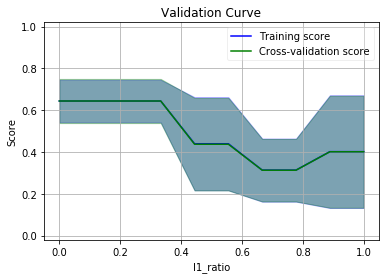

In [23]:
from sklearn.linear_model import SGDClassifier

est = SGDClassifier(loss = 'hinge', # gives a linear SVM
                    l1_ratio=0.0,   # Elastic Net mixing parameter; 0 corresponds to L2 penalty, l1_ratio=1 to L1
                    class_weight='balanced',
                    max_iter=100,
                    )

plot_validation_curve(est, X_train, y_train, 
                      param_name='l1_ratio', 
                      param_range=np.linspace(0,1,10), 
                      scoring='f1', # f1 is the harmonic mean of precision and recall
                      semilogx=False)


# and so, the SGD gives better 'f1' score when l1_ratio is closer to 0 (Ridge) than to 1 (Lasso)
# caveat: this is an example; more reliable model should use other optimized hyperparams

###### [Please move to the next notebook: *3-B. Model Development*](3-B. Model Development.ipynb)